In [26]:

from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from skimage.color import rgb2gray,rgb2hsv
from skimage.filters import threshold_otsu, rank
from skimage.morphology import disk
from skimage.filters import gaussian
from skimage.filters import median
from skimage import data
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte
import matplotlib
import matplotlib.pyplot as plt
import cv2
from cv2 import threshold 
from collections import Counter 
from skimage.transform import hough_line, hough_line_peaks, rotate
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


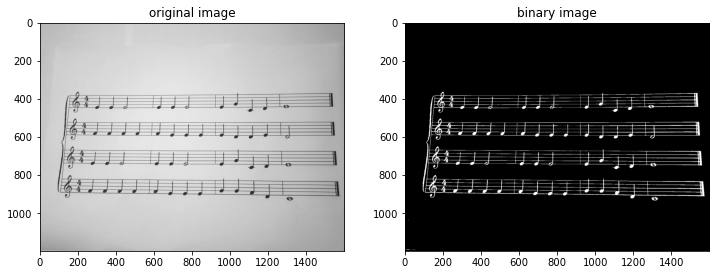

In [34]:
def binarize(img):
    threshold_global_otsu = threshold_otsu(img)
    global_otsu = img < threshold_global_otsu
    return global_otsu

img = io.imread('test.jpg', as_gray = True) 

binary_img = np.ones(img.shape)
L = img.shape[0]
W = img.shape[1]
HL = img.shape[0]//2
HW = img.shape[1]//2

binary_img[0:HL, 0:HW] = binarize(img[0:HL, 0:HW])
binary_img[0:HL, HW:W] = binarize(img[0:HL, HW:W])
binary_img[HL:L, 0:HW] = binarize(img[HL:L, 0:HW])
binary_img[HL:L, HW:W] = binarize(img[HL:L, HW:W])

show_images([img,binary_img],['original image','binary image'])



In [35]:
def get_ref_lengths(img):
    num_rows = img.shape[0]  # Image Height (number of rows)
    num_cols = img.shape[1]  # Image Width (number of columns)
    rle_image_white_runs = []  # Cumulative white run list
    rle_image_black_runs = []  # Cumulative black run list
    sum_all_consec_runs = []  # Cumulative consecutive black white runs

    for i in range(num_cols):
        col = img[:, i]
        rle_col = []
        rle_white_runs = []
        rle_black_runs = []
        run_val = 0  # (The number of consecutive pixels of same value)
        run_type = col[0]  # Should be 255 (white) initially
        for j in range(num_rows):
            if (col[j] == run_type):
                # increment run length
                run_val += 1
            else:
                # add previous run length to rle encoding
                rle_col.append(run_val)
                if (run_type == 1):
                    rle_black_runs.append(run_val)
                else:
                    rle_white_runs.append(run_val)

                # alternate run type
                run_type = col[j]
                # increment run_val for new value
                run_val = 1

        # add final run length to encoding
        rle_col.append(run_val)
        if (run_type == 1):
            rle_black_runs.append(run_val)
        else:
            rle_white_runs.append(run_val)

        # Calculate sum of consecutive vertical runs
        sum_rle_col = [sum(rle_col[i: i + 2]) for i in range(len(rle_col))]

        # Add to column accumulation list
        rle_image_white_runs.extend(rle_white_runs)
        rle_image_black_runs.extend(rle_black_runs)
        sum_all_consec_runs.extend(sum_rle_col)
    
    white_runs = Counter(rle_image_white_runs)
    black_runs = Counter(rle_image_black_runs)
    black_white_sum = Counter(sum_all_consec_runs)

    line_spacing = white_runs.most_common(1)[0][0]
    line_width = black_runs.most_common(1)[0][0]
    width_spacing_sum = black_white_sum.most_common(1)[0][0]

    print(line_width,line_spacing )
    return line_width, line_spacing

line_width, line_spacing = get_ref_lengths(binary_img)

2 15


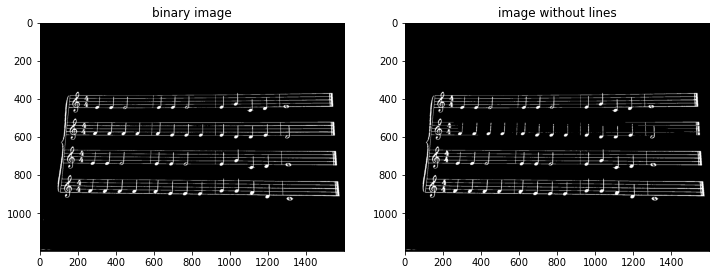

In [36]:
# projection method for line removal

row_white_pixels_histogram = []
staff_lines = np.ones(img.shape[0])
threshold = 0.4 * binary_img.shape[1]
img_without_lines = binary_img.copy()
begin_staff_group = []

for i in range(binary_img.shape[0]):
    num_white_pixels = 0
    for j in range(binary_img.shape[1]):
        if (binary_img[i][j] == 1):
            num_white_pixels += 1

        row_white_pixels_histogram.append(num_white_pixels)

    if(num_white_pixels > threshold):
        staff_lines[i] = 1
        img_without_lines[i,:] = 0
    else:
        staff_lines[i] = 0  
            


staff_group_height = 5 * (line_width + line_spacing) - line_spacing
i=0 
while (i < len(staff_lines)):
    if(staff_lines[i] == 1):
        begin_staff_group.append(i)
        i = i + staff_group_height
    else:
        i = i + 1
        

arr = np.ones((line_width+1,line_width+1))
dilation=binary_dilation(img_without_lines, selem=arr, out=None)
close=binary_erosion(dilation, selem=arr, out=None) 

show_images([binary_img, close],['binary image', 'image without lines'])      

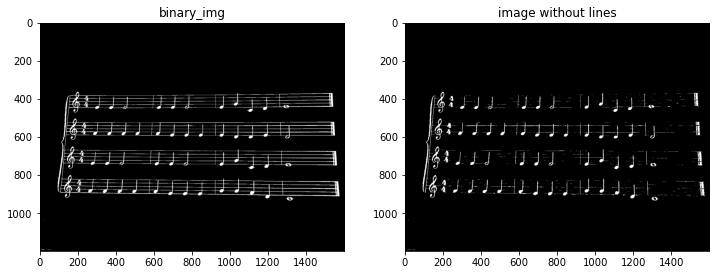

In [37]:
#  mophology method for line removal

binary_img = img_as_ubyte(binary_img)
l=np.ones((1,28))
vertical_shape = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, np.uint8(l))
close = cv2.morphologyEx(vertical_shape, cv2.MORPH_CLOSE, np.uint8(l))

img_without_lines = (binary_img -close).astype('ubyte')

# arr = np.ones((line_width+1, line_width+1))
# dilation=binary_dilation(img_without_lines, selem=arr, out=None)
# close_img=binary_erosion(dilation, selem=arr, out=None) 


show_images([ binary_img, close_img],['binary_img','image without lines'])

